# TP4


### Environment Setup

In [1]:
##### Import Libraries #####
import pandas as pd
import os
from tqdm.notebook import tqdm
import numpy as np 
import matplotlib.pyplot as plt  
import statsmodels.api as sm    
import seaborn as sns 

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score,roc_curve, roc_auc_score, RocCurveDisplay, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier


In [2]:
##### Directories #####
#Taking into account that 'TP4' is outside any folder
## General Folders ##
docs = './docs/'
input = './input/'
output = './output/'

## Input Data Bases ##
EPH_hogar = 'EPH_usu_hogar_T123.xlsx'
EPH_hog_dir = os.path.join(input, EPH_hogar)

EPH_individual = 'EPH_usu_individual_T123.xlsx'
EPH_indiv_dir = os.path.join(input, EPH_individual)

## Intermediary Ouput Databases ##
EPH_AMBA_raw_dir = os.path.join(output, 'EPH_AMBA_raw.xlsx')
EPH_AMBA_clean_dir = os.path.join(output, 'EPH_AMBA_clean.xlsx')

respondieron_dir = os.path.join(output, 'Respondieron.xlsx')
norespondieron_dir = os.path.join(output, 'NoRespondieron.xlsx')

## Output Imagenes ##
corr_map_dir = os.path.join(output, 'mapa_de_correlaciones.png')
box_plot_outliers_dir = os.path.join(output, 'box_plot_outliers.png')

## Parte 1 - Análisis de la base de hogares y cálculo de pobreza.
  Ahora que ya se han familiarizado con la Encuesta Permanente de Hogares (EPH), asegúrense de estar calculando niveles de pobreza a nivel individual y a nivel de hogar similares a los que calcula el INDEC para la misma región. Además, asegúrense de estar realizando una limpieza de la base con mayor dedicación y entendimiento de sus variables.

##### 1
  Descarguen la base de microdatos de la EPH correspondiente al primer trimestre de 2023 (la base de hogares se llama [usu_hogar_T123.xls](./input/EPH_usu_hogar_T123.xlsx). Importen los datos de la encuesta de hogar y, al igual que en el TP2, conserven sólo las observaciones que corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires o del Gran Buenos Aires.

In [3]:
#Leemos y copiamos dicha base
dataframe = pd.read_excel(EPH_hog_dir)
df_EPH_hog = dataframe.copy()

#Nos quedamos solo con las Obs de CABA y GBA (Aglomerados: 32, 33)
df_EPH_hog_AMBA = df_EPH_hog[df_EPH_hog['AGLOMERADO'].isin([32, 33])]

#Testeamos si lo importamos correctamente:
df_EPH_hog_AMBA.head(5)

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,REALIZADA,REGION,MAS_500,AGLOMERADO,PONDERA,IV1,...,GDECCFR,PDECCFR,ADECCFR,PONDIH,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
9,TQRMNORVYHMOTSCDEIJAH00802517,2023,1,1,1,1,S,33,1066,1,...,12.0,NaN,12,0,1,0,98,0,0,0
10,TQRMNOSQRHLLTTCDEIJAH00719390,2023,1,1,1,1,S,33,2270,2,...,6.0,NaN,7,4733,1,0,2,0,0,0
11,TQSMNOSQRHLLTTCDEIJAH00719389,2023,1,1,1,1,S,33,2161,1,...,7.0,NaN,8,2672,1,0,98,0,0,0
35,TQRMNORTUHKOQQCDEIJAH00780489,2023,1,1,1,1,S,33,3097,1,...,8.0,NaN,9,4844,1,0,98,0,0,0
98,TQRMNOUTRHKNQMCDEIJAH00802590,2023,1,1,1,1,S,33,2571,1,...,8.0,NaN,9,3482,1,0,97,0,0,0


#### 2
 Unan la tabla de la encuesta individual con la de la encuesta de hogar. Asegúrense
de estar usando las variables CODUSU y NRO HOGAR.


In [4]:
#Leemos y copiamos dicha base
dataframe = pd.read_excel(EPH_indiv_dir)
df_EPH_indiv = dataframe.copy()
df_EPH_indiv_AMBA = df_EPH_indiv[df_EPH_indiv['AGLOMERADO'].isin([32, 33])]

In [5]:
#Unimos Ambas bases de Datos, tal que: 1 Obs = Individuo + datos de su hogar
df_EPH_AMBA = pd.merge(df_EPH_indiv_AMBA, df_EPH_hog_AMBA, on=['CODUSU','NRO_HOGAR'], how='inner', suffixes=('_H', '_I')) #solo se queda con las rows que en ambas bases tienen el mismo CODUSU, 'right' lo haria con hogar y NaN faltantes

#Testeamos si lo importamos correctamente:
with pd.option_context('display.max_columns', None): #nos permite temporalmente sacar la restriccion al limite de cols
  df_EPH_AMBA.head(50)

In [6]:
suffixes = {'_H': {}, '_I': {}}
cols_w_suffix = set()

# Find columns with suffixes
for suffix in list(suffixes.keys()):
    cols_w_suffix.update(col[:-len(suffix)] for col in df_EPH_AMBA.columns if col.endswith(suffix))

# Create lists and dictionaries for operations
columns_to_drop = []
columns_to_rename = {}
columns_different= []

# Chequeamos el nombre de las columnas y actualizamos
for col in cols_w_suffix:
    col_1_name = col + list(suffixes.keys())[0]
    col_2_name = col + list(suffixes.keys())[1]

    if all(df_EPH_AMBA[col_1_name] == df_EPH_AMBA[col_2_name]):
        print('Las columnas tiene los mismos valores')
        columns_to_drop.append(col_2_name)
        columns_to_rename[col_1_name] = col
    else:
        print(f'{col_1_name} y {col_2_name} tienen diferentes valores, entonces mantenemos las dos')
        columns_different.append(col)


df_EPH_AMBA.drop(columns=columns_to_drop, inplace=True)
df_EPH_AMBA.rename(columns=columns_to_rename, inplace=True)

The columns with have the same values
The columns with have the same values
PDECIFR_H and PDECIFR_I have different values, so we kept both
The columns with have the same values
The columns with have the same values
The columns with have the same values
The columns with have the same values
The columns with have the same values
PDECCFR_H and PDECCFR_I have different values, so we kept both
IDECIFR_H and IDECIFR_I have different values, so we kept both
The columns with have the same values
The columns with have the same values
IDECCFR_H and IDECCFR_I have different values, so we kept both
The columns with have the same values
The columns with have the same values
The columns with have the same values
The columns with have the same values
The columns with have the same values
The columns with have the same values
The columns with have the same values
The columns with have the same values


In [7]:
# Verificando manualmente la contruccion de la encuesta determinamos que los valores que son diferentes nos quedaremos con solo uno de los valores por simplicidad, elegimos los de hogar ya que los individuales son construidos arbitrariamente con ponderadores.
df_EPH_AMBA.drop(columns=[col + '_I' for col in columns_different], inplace=True)
df_EPH_AMBA.rename(columns={col + '_H': col for col in columns_different}, inplace=True)

# Dado que estas columnas son constantes en toda la base de datos y no aportan información tambien las eliminamos
df_EPH_AMBA.drop(columns=['ANO4', 'TRIMESTRE', 'AGLOMERADO', 'MAS_500'], inplace=True)

df_EPH_AMBA.to_excel(EPH_AMBA_raw_dir, index=False)

print(f'DataFrame saved to {EPH_AMBA_raw_dir}')

DataFrame saved to ./output/EPH_AMBA_raw.xlsx


#### 3
 Limpien la base de datos tomando criterios que hagan sentido, tanto para el tratamiento de valores faltantes, <span style="color:red">de outliers</span>, como así también decidan qué variables categóricas y strings usarán y transfórmenlas de forma que haga sentido para los ejercicios siguientes. Justifiquen sus decisiones.

In [8]:
#Definomos la funcion para eliminar variables con missings

def col_drop_if(drop_if_missings=False, other_criteria=[], df=df_EPH_AMBA):
  #dropear si cualquier valor de la lista esta en la columna
  if other_criteria:
    columns_to_drop = [col for col in df.columns if df[col].isin(other_criteria).any()]
    df = df.drop(columns=columns_to_drop)
  
  #dropear si hay missinings(valores vacios)
  if drop_if_missings:
    df.dropna(axis=1, inplace=True)

  return df


#Definimos la funcion para eliminar observaciones negativas

def drop_neg_obs(cols=[], df=df_EPH_AMBA):
  #transformamos la columna a valores numericos por las dudas
  df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
  #(Checko si es neg) => Chequeo si algun valor es negativo => If si = True => Iniverto todo con "~" y me quedo solo convalores positivos
  df = df[~(df[cols] < 0).any(axis=1)]
  return df


#
def replace_rename_col(col=None, replace_dic={}, new_name=None, df=df_EPH_AMBA):
  df[col] = df[col].replace(replace_dic)
  if new_name:
    df = df.rename(columns={col: new_name})
  return df


#
def categorical_to_dummy(col=None, dummy_names_dic={}, keep_old_col=False, df=df_EPH_AMBA):
  #le agrega a las keys del diccionario la col+"_" como prefijo --> Nos permite ser mas robusto, por si hay valores que no estan en el diccionario, generandolas con nombre identificable igualmente
  complete_dummy_names_dic = {col+ '_' + key: value for key, value in dummy_names_dic.items()}
  #Genera las dummies a partir de los valores categoricos y renombra las dummies segun el diccionario dado
  new_dummies = pd.get_dummies(df[col], prefix=col, dtype=int).rename(columns=complete_dummy_names_dic)
  
  #si keep_old_col = False => drop col vieja
  if ~keep_old_col:
      df = df.drop(columns=[col])

  #le agrega las nuevas dummies al df
  df = pd.concat([df, new_dummies], axis=1)
  return df

In [9]:
# Guardamos una copia del DataFrame original por precaución
df_EPH_AMBA_clean = df_EPH_AMBA.copy()

# Eliminamos observaciones con valores negativos en columnas específicas
df_EPH_AMBA_clean = drop_neg_obs(
                                  cols=['CH06', 'P21', 'IPCF', 'ITF', 'PP08D1', 'PP08J3',  'PP08D4', 'PP08F1','PP08F2', 'PP08J1', 'PP08J2'],
                                  df=df_EPH_AMBA_clean)


# Eliminamos columnas con valores faltantes
df_EPH_AMBA_clean = col_drop_if(
                                  drop_if_missings=True,
                                  other_criteria=[],
                                  df=df_EPH_AMBA_clean)


# Reemplazamos valores en la columna 'IV5' y renombramos la columna
df_EPH_AMBA_clean = replace_rename_col(
                                  col='IV5', replace_dic={'1': 1, '2': 0},
                                  new_name='techo_revestido',
                                  df=df_EPH_AMBA_clean)

# Convertimos columnas categóricas en columnas de variables dummy
categorical_list = [
  {'col': 'IV3',
  'dummy_names_dic': {
      '1': 'pisos_revestido',
      '2': 'pisos_cemento',
      '3': 'pisos_sin_revestir',
      '4': 'pisos_sin_especificar'
      }
  },
  {'col': 'IV9',
  'dummy_names_dic': {
      '1': 'baño_adentro',
      '2': 'baño_afuera',
      '3': 'baño_sin'
      }
  },
]

for i in range(0, len(categorical_list)):
  c = categorical_list[i]
  df_EPH_AMBA_clean = categorical_to_dummy(
                                  col=c['col'],
                                  dummy_names_dic=c['dummy_names_dic'],
                                  df=df_EPH_AMBA_clean)

# Muestra el DataFrame resultante con todas las transformaciones
with pd.option_context('display.max_columns', None, 'display.max_rows', 5):
  display(df_EPH_AMBA_clean)

,CODUSU,NRO_HOGAR,COMPONENTE,H15,REGION,PONDERA,CH03,CH04,CH05,CH06,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,PONDIIO,TOT_P12,DECINDR,RDECINDR,GDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF,DECIFR,RDECIFR,GDECIFR,ADECIFR,IPCF,DECCFR,RDECCFR,GDECCFR,ADECCFR,PONDIH,REALIZADA,IV1,IV2,IV4,techo_revestido,IV6,IV7,IV8,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4,pisos_revestido,pisos_cemento,pisos_sin_revestir,pisos_sin_especificar,IV9_0,baño_adentro,baño_afuera
0,TQRMNORUYHLMSMCDEIJAH00719364,1,1,1,1,1545,1,2,1957-10-17 00:00:00,65,1,1.0,1,2,0,2,1,3,1,2,3,0,1,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0.0,0,1545,0,4,4,4.0,4,1690,60000,0,0,0,0,0,0,0,0,0,0,0,60000,135000,4,4,4.0,4,67500.0,5,5,5.0,6,2540,1,1,3,4,1,1,2,1,1,1,2,2,2,3,1,2,0,1,1,1,2,0,2,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,0,2,1,0,2,0,0,0,1,0,0,0,0,1,0
1,TQRMNORUYHLMSMCDEIJAH00719364,1,2,1,1,1545,2,1,1952-04-07 00:00:00,70,1,1.0,1,2,0,2,1,1,1,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,10000,1,1,1.0,1,3074,0,5,4,4.0,5,2910,65000,0,0,0,0,0,0,0,0,0,0,0,65000,135000,4,4,4.0,4,67500.0,5,5,5.0,6,2540,1,1,3,4,1,1,2,1,1,1,2,2,2,3,1,2,0,1,1,1,2,0,2,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,0,2,1,0,2,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7616,TQRMNOPTXHKORSCDEIJAH00780269,1,1,1,1,1193,1,2,1977-07-31 00:00:00,45,5,1.0,1,2,0,2,1,1,1,2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,49000,3,2,3.0,3,1614,32000,5,5,5.0,5,1592,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12.0,12,0.0,12,12,12.0,12,0,1,1,3,2,2,1,1,1,1,1,1,2,1,3,3,2,0,2,2,2,0,0,0,0,2,2,2,1,2,2,2,2,2,2,1,1,2,2,2,2,2,1,2,2,1,2,2,2,2,3,0,3,1,2,3,0,0,0,1,0,0,0,0,1,0
7617,TQRMNOPTXHKORSCDEIJAH00780269,1,2,1,1,1193,3,1,2005-06-17 00:00:00,17,5,1.0,1,2,0,4,1,1,1,4,3,0,4,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0.0,0,1193,0,0,0,0.0,0,1193,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12.0,12,0.0,12,12,12.0,12,0,1,1,3,2,2,1,1,1,1,1,1,2,1,3,3,2,0,2,2,2,0,0,0,0,2,2,2,1,2,2,2,2,2,2,1,1,2,2,2,2,2,1,2,2,1,2,2,2,2,3,0,3,1,2,3,0,0,0,1,0,0,0,0,1,0


13.5
Se eliminaron 287 outliers de 6370 observaciones


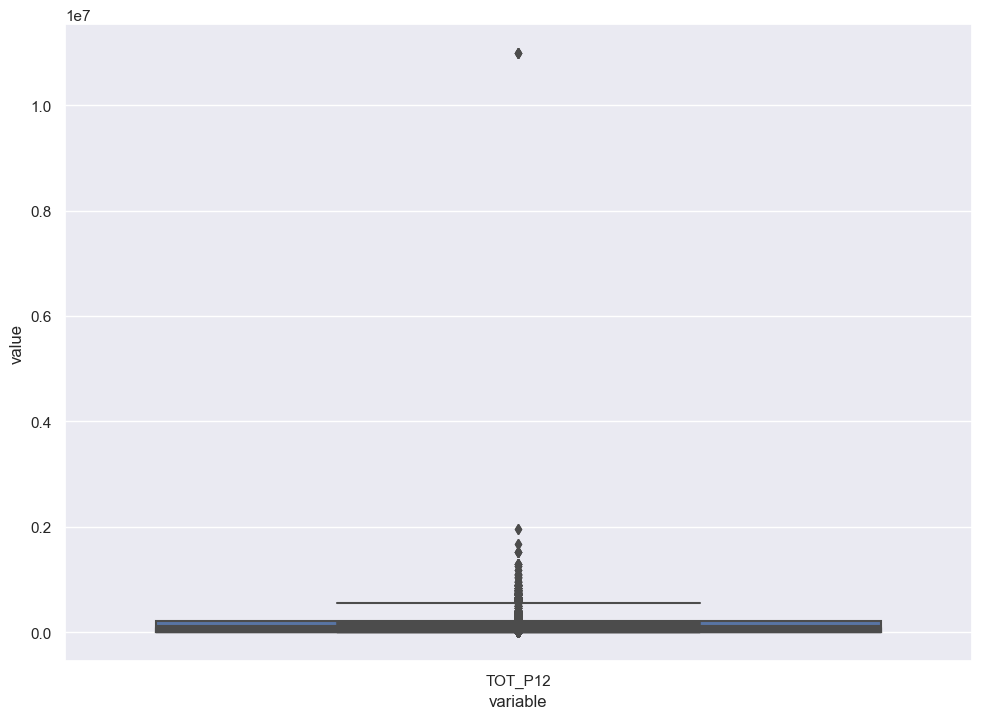

In [10]:
# Lista de columnas con outliers
outliers = ['CH06','ITF', 'IPCF', 'P21', 'TOT_P12']

# Seteamos el tamapo0
sns.set(rc={'figure.figsize': (11.7, 8.27)})


n_obs = len(df_EPH_AMBA_clean)

# Creamos un boxplot para cada variable
for variable in outliers:
    # Creamos un box plot
    sns.boxplot(x="variable", y="value", data=pd.melt(df_EPH_AMBA_clean[[variable]]))
    plt.savefig(box_plot_outliers_dir, dpi=300, bbox_inches='tight') ###check

    # Calculamos el upper limit del rango intercuartil. Teniendo en cuenta las respuestas de cero para elegir el cuartil inferior y superior.
    Q1 = df_EPH_AMBA_clean[variable].quantile(0)
    Q3 = df_EPH_AMBA_clean[variable].quantile(0.95)
    IQR = Q3 - Q1

    upper_limit = Q3 + 1.5 * IQR

    # Identificamos y elimninamos los outliers
    outlier_rows = (df_EPH_AMBA_clean[variable] >= upper_limit)

    df_EPH_AMBA_clean = df_EPH_AMBA_clean[~outlier_rows]

print(upper_limit)
print(f'Se eliminaron {(outlier_rows== True).sum()} outliers de {n_obs} observaciones')


#### 4
 Construyan variables (mínimo 2) que no estén en la base pero que sean relevantes para predecir individuos bajo la línea de pobreza (por ejemplo, la proporción de niños en el hogar, si el cónyuge trabaja).

In [11]:
#Crear variable: Conyugue Trabaja

# Crear una columna dummy inicializada en 0
df_EPH_AMBA_clean['CONYUGUE_TRABAJA'] = 0

# Identificar al cónyuge en cada hogar y verificar si trabaja
conyuge_trabaja_mask = (df_EPH_AMBA_clean['CH03'] == '02') & (df_EPH_AMBA_clean['ESTADO'] == '1')

# Asignar el valor 1 a la columna dummy para el cónyuge que trabaja (Tranformamos de True/False a 1/0)
df_EPH_AMBA_clean.loc[conyuge_trabaja_mask, 'CONYUGUE_TRABAJA'] = 1

# Broadcast del valor de la columna dummy a todos los miembros del hogar(Si alguien(conyugue que trabaja) del Hogar tiene valor =1, aplicarselo a todos en el hogar)
df_EPH_AMBA_clean['CONYUGUE_TRABAJA'] = df_EPH_AMBA_clean.groupby(['CODUSU', 'NRO_HOGAR'])['CONYUGUE_TRABAJA'].transform('max')

In [12]:
#Crear Variable: Proporción de niños en el hogar
df_EPH_AMBA_clean['PROP_NIÑOS'] = df_EPH_AMBA_clean['IX_MEN10'] / df_EPH_AMBA_clean['IX_TOT']

In [13]:
#Crear Variable: Hacinamiento

#Calculamos la cantidad de personas por habitación
df_EPH_AMBA_clean['HABITANTES_P_H'] = df_EPH_AMBA_clean['IX_TOT'] / df_EPH_AMBA_clean['II2'] 

#Si #Personas x Habitación es >3, es considerado Hacinamiento
df_EPH_AMBA_clean['HACINAMIENTO'] = np.where(df_EPH_AMBA_clean['HABITANTES_P_H'] >=3, 1, 0)


In [14]:
#Crear Variable: Hogar con acceso al sistema financiero 
#Utilizamos las vars: prestamos a bancos/financieras (V15 = 1), tarjeta de credito (V16 = 1), plazo fijo (V10 = 1). Si alguna de estsas es verdad, significa que tienen accesso al sistema financiero

df_EPH_AMBA_clean['ACCESO_FINANCIERO'] = 1 if any(df_EPH_AMBA_clean[['V10', 'V15', 'V16']].eq(1).any(axis=1)) else 0

In [15]:
# Mostrar el DataFrame resultante
rows = 30
with pd.option_context('display.max_columns', None,'display.max_rows',rows):
  display(df_EPH_AMBA_clean.head(rows))

,CODUSU,NRO_HOGAR,COMPONENTE,H15,REGION,PONDERA,CH03,CH04,CH05,CH06,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,PONDIIO,TOT_P12,DECINDR,RDECINDR,GDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF,DECIFR,RDECIFR,GDECIFR,ADECIFR,IPCF,DECCFR,RDECCFR,GDECCFR,ADECCFR,PONDIH,REALIZADA,IV1,IV2,IV4,techo_revestido,IV6,IV7,IV8,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4,pisos_revestido,pisos_cemento,pisos_sin_revestir,pisos_sin_especificar,IV9_0,baño_adentro,baño_afuera,CONYUGUE_TRABAJA,PROP_NIÑOS,HABITANTES_P_H,HACINAMIENTO,ACCESO_FINANCIERO
0,TQRMNORUYHLMSMCDEIJAH00719364,1,1,1,1,1545,1,2,1957-10-17 00:00:00,65,1,1.0,1,2,0,2,1,3,1,2,3,0,1,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0.0,0,1545,0,4,4,4.0,4,1690,60000,0,0,0,0,0,0,0,0,0,0,0,60000,135000,4,4,4.0,4,67500.00,5,5,5.0,6,2540,1,1,3,4,1,1,2,1,1,1,2,2,2,3,1,2,0,1,1,1,2,0,2,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,0,2,1,0,2,0,0,0,1,0,0,0,0,1,0,0,0.000000,2.000000,0,1
1,TQRMNORUYHLMSMCDEIJAH00719364,1,2,1,1,1545,2,1,1952-04-07 00:00:00,70,1,1.0,1,2,0,2,1,1,1,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,10000,1,1,1.0,1,3074,0,5,4,4.0,5,2910,65000,0,0,0,0,0,0,0,0,0,0,0,65000,135000,4,4,4.0,4,67500.00,5,5,5.0,6,2540,1,1,3,4,1,1,2,1,1,1,2,2,2,3,1,2,0,1,1,1,2,0,2,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,0,2,1,0,2,0,0,0,1,0,0,0,0,1,0,0,0.000000,2.000000,0,1
2,TQRMNOSRQHJNSOCDEIJAH00802640,1,1,1,1,8423,1,1,1986-09-26 00:00:00,36,1,4.0,1,2,0,4,1,1,1,4,1,2,0,0,0,0,0,0,0,0,0,0,0,0,40000,2,2,2.0,2,14906,0,2,2,2.0,2,14856,0,0,0,0,0,0,0,0,0,0,0,0,0,70000,2,1,1.0,2,23333.33,1,1,1.0,1,14082,1,1,3,2,1,1,2,1,1,3,2,2,2,3,2,2,0,1,1,1,2,0,2,0,3,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,3,1,2,2,1,98,0,0,0,1,0,0,0,0,1,0,0,0.333333,1.500000,0,1
3,TQRMNOSRQHJNSOCDEIJAH00802640,1,2,1,1,8423,2,2,1994-05-02 00:00:00,28,1,4.0,1,2,0,4,1,1,1,4,1,2,0,0,0,0,0,0,0,0,0,0,0,0,30000,2,2,2.0,2,15878,0,2,2,2.0,2,15231,0,0,0,0,0,0,0,0,0,0,0,0,0,70000,2,1,1.0,2,23333.33,1,1,1.0,1,14082,1,1,3,2,1,1,2,1,1,3,2,2,2,3,2,2,0,1,1,1,2,0,2,0,3,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,3,1,2,2,1,98,0,0,0,1,0,0,0,0,1,0,0,0.333333,1.500000,0,1
4,TQRMNOSRQHJNSOCDEIJAH00802640,1,3,0,1,8423,3,2,2014-03-20 00:00:00,9,5,4.0,1,1,1,2,2,1,1,1,4,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,8423,0,0,0,0.0,0,8423,0,0,0,0,0,0,0,0,0,0,0,0,0,70000,2,1,1.0,2,23333.33,1,1,1.0,1,14082,1,1,3,2,1,1,2,1,1,3,2,2,2,3,2,2,0,1,1,1,2,0,2,0,3,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,3,1,2,2,1,98,0,0,0,1,0,0,0,0,1,0,0,0.333333,1.500000,0,1
5,TQRMNOSWQHJLQRCDEIJAH00796254,1,1,1,1,2356,1,1,1900-01-01 00:00:00,59,5,1.0,1,2,0,6,2,1,1,5,1,3,0,0,0,0,0,0,0,0,0,0,0,0,120000,7,6,7.0,7,3311,0,8,8,8.0,9,3608,0,0,0,0,0,0,0,0,0,0,0,0,0,360000,9,9,9.0,9,180000.00,9,9,9.0,10,4090,1,1,2,4,1,1,1,1,1,1,1,2,2,2,2,2,0,1,2,2,2,0,2,0,6,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,1,0,98,0,0,0,1,0,0,0,0,1,0,0,0.000000,1.000000,0,1
9,TQRMNOPYVHLMRLCDEIJAH00719346,1,3,1,1,2086,3,1,2004-05-04 00:00:00,18,5,4.0,1,1,1,4,2,1,1,3,3,0,3,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0.0,0,2086,0,0,0,0.0,0,2086,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12.0,12,0.00,12,12,12.0,12,0,1,1,4,2,2,1,2,1,1,3,2,2,2,4,2,2,0,1,1,2,2,0,2,0,1,1,1,1,2,2,2,2,2,1,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,3,0,3,2,0,98,0,0,0,1,0,0,0,0,0,1,0,0.000000,1.500000,0,1
13,TQRMNOSRXHKMLUCDEIIAD00780093,1,3,1,1,2361,3,2,2012-06-07 00:00:00,10,5,1.0,1,1,2,2,2,1,1,1,3,0,3,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0.0,0,2361,0,0,0,0.0,0,2361,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12.0,12,0.00,12,12,12.0,12,0,1,2,4,2,1,1,1,1,1,1,2,2,2,4,3,2,0,1,1,1,2,0,2,0,3,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,4,1,3,1,2,98,0,0,0,1,0,0,0,0,1,0,0,0.250000,1.333333,0,1
14

In [16]:

#Eliminamos las observacion de variables que tienen ns/nr que son de nuestro interés ()


df_EPH_AMBA_clean = df_EPH_AMBA_clean[~((df_EPH_AMBA_clean['CH08'] == 9) | (df_EPH_AMBA_clean['NIVEL_ED'] == 9) | (df_EPH_AMBA_clean['CAT_OCUP'] == 9) | (df_EPH_AMBA_clean['CH07'] == 9) )]

df_EPH_AMBA_clean = df_EPH_AMBA_clean [df_EPH_AMBA_clean  != 99].dropna()



#### 5
 Presenten un gráfico (que no sea de barras) para describir la interacción
o correlación entre dos o más variables.


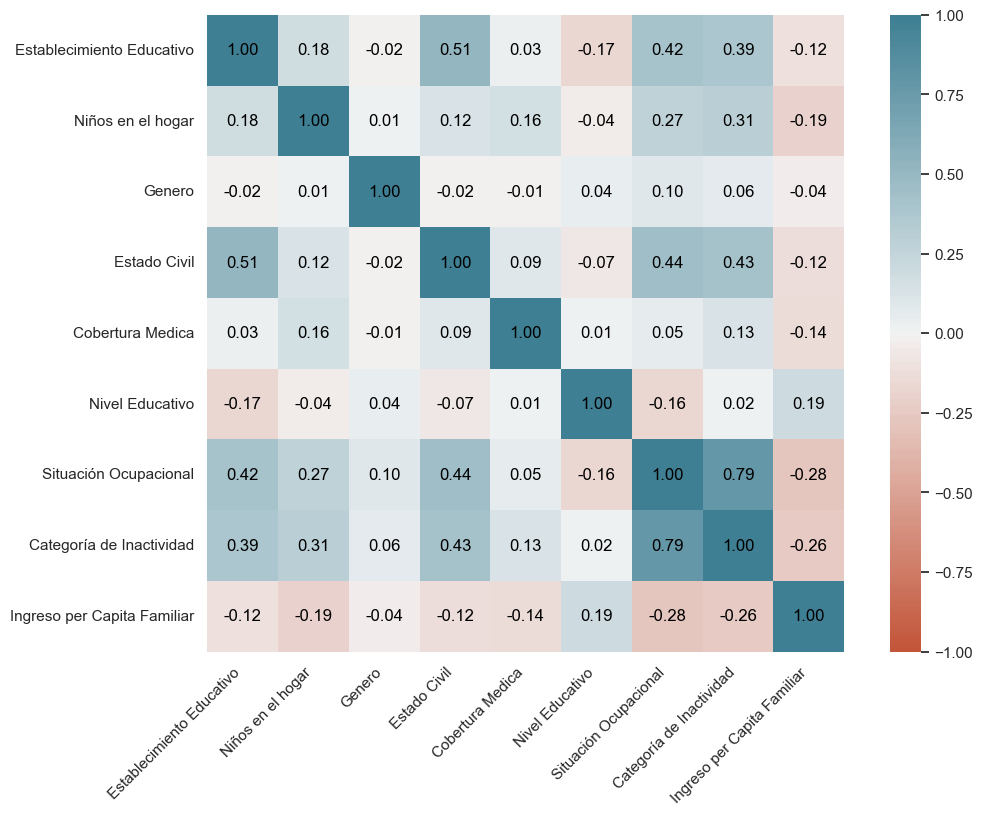

In [17]:



import seaborn as sns

datos_temporal = df_EPH_AMBA_clean.copy()




# Para restaurar el nombre original, puedes eliminar la columna renombrada de 'datos_temporal'. Utilizamos un correlograma, en el que tomamos
#de partida variables trabajadas en el TP2. 

datos_temporal.rename(columns={'CH04': 'Genero'}, inplace=True)
datos_temporal.rename(columns={'CH07': 'Estado Civil'}, inplace=True)
datos_temporal.rename(columns={'CH08': 'Cobertura Medica'}, inplace=True)
datos_temporal.rename(columns={'NIVEL_ED': 'Nivel Educativo'}, inplace=True)
datos_temporal.rename(columns={'ESTADO': 'Situación Ocupacional'}, inplace=True)
datos_temporal.rename(columns={'CAT_INAC': 'Categoría de Inactividad'}, inplace=True)
datos_temporal.rename(columns={'IPCF': 'Ingreso per Capita Familiar'}, inplace=True)
datos_temporal.rename(columns={'IX_MEN10': 'Niños en el hogar'}, inplace=True)
datos_temporal.rename(columns={'CH11': 'Establecimiento Educativo'}, inplace=True)



# Creamos una lista de las variables que queremos incluir en la matriz de correlaciones

variables_a_incluir= ['Establecimiento Educativo', 'Niños en el hogar', 'Genero', 'Estado Civil', 'Cobertura Medica', 'Nivel Educativo', 'Situación Ocupacional', 'Categoría de Inactividad', 'Ingreso per Capita Familiar']


# Crear un DataFrame temporal con las variables seleccionadas
datos_temporal = datos_temporal[variables_a_incluir]

#Creamos la matriz de correlaciones
corr = datos_temporal.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)


# Usamos un for anidado para recorrer las filas y columnas de la matriz de correlación y agregar etiquetas a las celdas del mapa de calor.
for i in range(len(variables_a_incluir)):
    for j in range(len(variables_a_incluir)):
        text = f"{corr.iloc[i, j]:.2f}"
        ax.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

# Establecer las etiquetas de las variables en el eje x
ax.set_xticklabels(
    variables_a_incluir,
    rotation=45,
    horizontalalignment='right'
)



#Eliminamos los datos temporales
del datos_temporal

#### 6
 Construyan la columna adulto equiv y la columna ad equiv hogar y luego dividan
la base en dos dataframes donde: uno conserve las personas que no reportaron
ITF (dataframe llamado respondieron) y otro conserve a las personas que no
reportaron ITF (llamado norespondieron). Además, agreguen a la base respondieron
una columna llamada ingreso necesario que sea el producto de la canasta
básica por ad equiv hogar. Agreguen a la base respondieron una columna llamada
pobre, que tome valor 1 si el ITF es menor al ingreso necesario que necesita
esa familia y 0 en caso contrario.


In [18]:
# Definir la tabla de equivalencias necesarias eneréticas según edad y sexo
equiv_energ = { 
  1 : { #si es 1 = Varón
    (0, 0.99): 0.35, #0.35 es el valor de un varón menor a 1 año
    (1, 1): 0.37,
    (2, 2): 0.46,
    (3, 3): 0.51,
    (4, 4): 0.55,
    (5, 5): 0.6,
    (6, 6): 0.64,
    (7, 7): 0.66,
    (8, 8): 0.68,
    (9, 9): 0.69,
    (10, 10): 0.79,
    (11, 11): 0.82,
    (12, 12): 0.85,
    (13, 13): 0.9,
    (14, 14): 0.96,
    (15, 15): 1,
    (16, 16): 1.03,
    (17, 17): 1.04,
    (18, 29): 1.02,
    (30, 45): 1,
    (46, 60): 1,
    (61, 75): 0.83,
    (75, 200): 0.74
  },
  2 : { #si es 2 = Mujer
    (0, 0.99): 0.35,
    (1, 1): 0.37,
    (2, 2): 0.46,
    (3, 3): 0.51,
    (4, 4): 0.55,
    (5, 5): 0.6,
    (6, 6): 0.64,
    (7, 7): 0.66,
    (8, 8): 0.68,
    (9, 9): 0.69,
    (10, 10): 0.7,
    (11, 11): 0.72,
    (12, 12): 0.74,
    (13, 13): 0.76,
    (14, 14): 0.76,
    (15, 15): 0.77,
    (16, 16): 0.77,
    (17, 17): 0.77,
    (18, 29): 0.76,
    (30, 45): 0.77,
    (46, 60): 0.76,
    (61, 75): 0.67,
    (75, 200): 0.63
    }
}

#Función para calcular 'adulto_equiv' basado en la edad y el sexo
def calculate_adulto_equiv(row):
  age = row['Edad'] #Obterner valor de "edad" del la row del df
  sex = row['CH04'] #Obterner valor de "edad" del la row del df
  
  if sex in equiv_energ: #Verificar,por las dudas, si el sexo está en el dic
     # Loopear los rangos de edad y valores en el dic
    for (start, end), value in equiv_energ[sex].items():
        if start <= age <= end: 
            return value #Devolver el valor correcto, si la edad está en el rango
  else: 
    print(f'Not found [age:{age}, sex:{sex}]')
  
  return 0 #devolver 0 como valor predeterminado

df_EPH_AMBA_clean.rename(columns={'CH06': 'Edad'}, inplace=True)

df_EPH_AMBA_clean['adulto_equiv'] = df_EPH_AMBA_clean.apply( #guarda el resultado de la funcion
    lambda row: calculate_adulto_equiv(row), axis=1)#Aplica calculate_adulto_equiv a cada fila del df

#Obtener 'ad_equiv_hogar' para cada row del df con groupby y transform
df_EPH_AMBA_clean['ad_equiv_hogar'] = df_EPH_AMBA_clean.groupby('CODUSU')['adulto_equiv'].transform('sum')
#Por el problema: base2 & floating point -> redondeamos a 2 decimales(estandar en esta base de datos)
df_EPH_AMBA_clean['ad_equiv_hogar'] = df_EPH_AMBA_clean['ad_equiv_hogar'].round(2)

In [19]:
# Generamos una dummy llamada respondieron, si indicaron un ingreso mayor a 0 se les asigna un 1
df_EPH_AMBA_clean['respondieron'] = (df_EPH_AMBA_clean['ITF'] > 0).astype(int)

# Sumamos para ver cuanta gente respondio
total_respondieron = df_EPH_AMBA_clean['respondieron'].sum()

print(total_respondieron)

# Repetimos para los que no respondieron (es decir los que reportaron un ingreso = 0)
df_EPH_AMBA_clean['norespondieron'] = (df_EPH_AMBA_clean['ITF'] == 0).astype(int)

total_norespondieron = df_EPH_AMBA_clean['norespondieron'].sum()

print(total_norespondieron)

# Creamos la base 'respondieron'
respondieron = df_EPH_AMBA_clean[df_EPH_AMBA_clean['ITF'] > 0]

# Creamos la base 'norespondieron'
norespondieron = df_EPH_AMBA_clean[df_EPH_AMBA_clean['ITF']==0]

# Creamos una nueva variable llamada ingreso necesario, que contiene la operacion exigida por la consigna
respondieron.loc[:,"ingreso_necesario"] = respondieron["ad_equiv_hogar"] * 57371.05

print(respondieron['ingreso_necesario'])

3900
2098
0        86056.5750
1        86056.5750
2       140559.0725
3       140559.0725
4       140559.0725
           ...     
7611    161786.3610
7612    141132.7830
7613    141132.7830
7614    141132.7830
7615     36143.7615
Name: ingreso_necesario, Length: 3900, dtype: float64


C:\Users\juliv\AppData\Local\Temp\ipykernel_17616\338114745.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron.loc[:,"ingreso_necesario"] = respondieron["ad_equiv_hogar"] * 57371.05


In [20]:
#Salvamos la base de Datos procesada por seguridad y facilitar su reuso
df_EPH_AMBA_clean.to_excel(EPH_AMBA_clean_dir, index=False)
print(f'DataFrame saved to {EPH_AMBA_clean_dir}')

# Mostrar el DataFrame resultante
with pd.option_context('display.max_columns', None,'display.max_rows', 100):
  display(df_EPH_AMBA_clean)

DataFrame saved to ./output/EPH_AMBA_clean.xlsx


,CODUSU,NRO_HOGAR,COMPONENTE,H15,REGION,PONDERA,CH03,CH04,CH05,Edad,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,PONDIIO,TOT_P12,DECINDR,RDECINDR,GDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF,DECIFR,RDECIFR,GDECIFR,ADECIFR,IPCF,DECCFR,RDECCFR,GDECCFR,ADECCFR,PONDIH,REALIZADA,IV1,IV2,IV4,techo_revestido,IV6,IV7,IV8,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4,pisos_revestido,pisos_cemento,pisos_sin_revestir,pisos_sin_especificar,IV9_0,baño_adentro,baño_afuera,CONYUGUE_TRABAJA,PROP_NIÑOS,HABITANTES_P_H,HACINAMIENTO,ACCESO_FINANCIERO,adulto_equiv,ad_equiv_hogar,respondieron,norespondieron
0,TQRMNORUYHLMSMCDEIJAH00719364,1,1,1,1,1545,1,2,1957-10-17 00:00:00,65.0,1,1.0,1,2,0,2.0,1,3,1,2,3,0,1,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0.0,0,1545,0,4,4,4.0,4,1690,60000,0,0,0,0,0,0,0,0,0,0,0,60000,135000,4,4,4.0,4,67500.00,5,5,5.0,6,2540,1,1,3,4,1,1,2,1,1,1,2,2,2,3,1,2,0,1,1,1,2,0,2,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,0,2,1.0,0,2,0,0,0,1,0,0,0,0,1,0,0,0.000000,2.0,0,1,0.67,1.50,1,0
1,TQRMNORUYHLMSMCDEIJAH00719364,1,2,1,1,1545,2,1,1952-04-07 00:00:00,70.0,1,1.0,1,2,0,2.0,1,1,1,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,10000,1,1,1.0,1,3074,0,5,4,4.0,5,2910,65000,0,0,0,0,0,0,0,0,0,0,0,65000,135000,4,4,4.0,4,67500.00,5,5,5.0,6,2540,1,1,3,4,1,1,2,1,1,1,2,2,2,3,1,2,0,1,1,1,2,0,2,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,0,2,1.0,0,2,0,0,0,1,0,0,0,0,1,0,0,0.000000,2.0,0,1,0.83,1.50,1,0
2,TQRMNOSRQHJNSOCDEIJAH00802640,1,1,1,1,8423,1,1,1986-09-26 00:00:00,36.0,1,4.0,1,2,0,4.0,1,1,1,4,1,2,0,0,0,0,0,0,0,0,0,0,0,0,40000,2,2,2.0,2,14906,0,2,2,2.0,2,14856,0,0,0,0,0,0,0,0,0,0,0,0,0,70000,2,1,1.0,2,23333.33,1,1,1.0,1,14082,1,1,3,2,1,1,2,1,1,3,2,2,2,3,2,2,0,1,1,1,2,0,2,0,3,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,3,1,2,2.0,1,98,0,0,0,1,0,0,0,0,1,0,0,0.333333,1.5,0,1,1.00,2.45,1,0
3,TQRMNOSRQHJNSOCDEIJAH00802640,1,2,1,1,8423,2,2,1994-05-02 00:00:00,28.0,1,4.0,1,2,0,4.0,1,1,1,4,1,2,0,0,0,0,0,0,0,0,0,0,0,0,30000,2,2,2.0,2,15878,0,2,2,2.0,2,15231,0,0,0,0,0,0,0,0,0,0,0,0,0,70000,2,1,1.0,2,23333.33,1,1,1.0,1,14082,1,1,3,2,1,1,2,1,1,3,2,2,2,3,2,2,0,1,1,1,2,0,2,0,3,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,3,1,2,2.0,1,98,0,0,0,1,0,0,0,0,1,0,0,0.333333,1.5,0,1,0.76,2.45,1,0
4,TQRMNOSRQHJNSOCDEIJAH00802640,1,3,0,1,8423,3,2,2014-03-20 00:00:00,9.0,5,4.0,1,1,1,2.0,2,1,1,1,4,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,8423,0,0,0,0.0,0,8423,0,0,0,0,0,0,0,0,0,0,0,0,0,70000,2,1,1.0,2,23333.33,1,1,1.0,1,14082,1,1,3,2,1,1,2,1,1,3,2,2,2,3,2,2,0,1,1,1,2,0,2,0,3,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,3,1,2,2.0,1,98,0,0,0,1,0,0,0,0,1,0,0,0.333333,1.5,0,1,0.69,2.45,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7612,TQRMNOPVVHKLRQCDEIJAH00780546,1,1,1,1,1236,1,1,1990-04-24 00:00:00,32.0,1,2.0,1,2,0,6.0,1,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,200000,9,9,9.0,9,1755,0,9,9,9.0,9,1892,0,0,0,0,0,0,0,0,0,0,0,0,0,480000,10,10,10.0,10,160000.00,9,9,9.0,9,2295,1,1,3,1,1,1,1,1,1,1,2,2,2,3,2,1,1,1,2,2,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,3,1,2,1.0,2,98,0,0,0,0,0,0,1,0,1,0,0,0.333333,1.5,0,1,1.00,2.46,1,0
7613,TQRMNOPVVHKLRQ

#### 7
 Para calcular la tasa de hogares bajo la línea de pobreza utilicen una sola observación por hogar y sumen el ponderador PONDIH que permite expandir la muestra de la EPH al total de la población que representa. ¿Cuál es la tasa de hogares bajo la línea de pobreza para el GBA? ¿Lograron que se asemeje al porcentaje que reporta el INDEC en sus informes?

In [21]:
#Deginimos la variable de pobre
respondieron['Pobre'] = np.where(respondieron['ITF'] < respondieron['ingreso_necesario'], 1, 0)

#Nos quedamos con una observación pro hogar y sumamos el ponderador PONDIH
hogares_pobreza = respondieron.groupby(['CODUSU','NRO_HOGAR']).agg({"Pobre" : "mean","PONDIH" : "sum"})
#Sumamos cuanto hay de cada uno.
suma_pobres= hogares_pobreza.groupby("Pobre").PONDIH.sum().to_frame()
porcentaje_pobres = suma_pobres.apply(lambda x:
                                                 100 * x / float(x.sum()))
print(porcentaje_pobres)

         PONDIH
Pobre          
0.0    59.91632
1.0    40.08368


C:\Users\juliv\AppData\Local\Temp\ipykernel_17616\3495539549.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['Pobre'] = np.where(respondieron['ITF'] < respondieron['ingreso_necesario'], 1, 0)


In [22]:
#Salvamos las base de Datos Respondieron y Norespondieron, procesada por seguridad y facilitar su reuso
respondieron.to_excel(respondieron_dir, index=False)
print(f'DataFrame saved to {respondieron_dir}')

norespondieron.to_excel(norespondieron_dir, index=False)
print(f'DataFrame saved to {norespondieron_dir}')

# Mostrar los DataFrame resultante
rows= 5
with pd.option_context('display.max_columns', None,'display.max_rows',rows):
  display(respondieron.head(rows))
  display(norespondieron.head(rows))

DataFrame saved to ./output/Respondieron.xlsx
DataFrame saved to ./output/NoRespondieron.xlsx


,CODUSU,NRO_HOGAR,COMPONENTE,H15,REGION,PONDERA,CH03,CH04,CH05,Edad,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,PONDIIO,TOT_P12,DECINDR,RDECINDR,GDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF,DECIFR,RDECIFR,GDECIFR,ADECIFR,IPCF,DECCFR,RDECCFR,GDECCFR,ADECCFR,PONDIH,REALIZADA,IV1,IV2,IV4,techo_revestido,IV6,IV7,IV8,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4,pisos_revestido,pisos_cemento,pisos_sin_revestir,pisos_sin_especificar,IV9_0,baño_adentro,baño_afuera,CONYUGUE_TRABAJA,PROP_NIÑOS,HABITANTES_P_H,HACINAMIENTO,ACCESO_FINANCIERO,adulto_equiv,ad_equiv_hogar,respondieron,norespondieron,ingreso_necesario,Pobre
0,TQRMNORUYHLMSMCDEIJAH00719364,1,1,1,1,1545,1,2,1957-10-17 00:00:00,65.0,1,1.0,1,2,0,2.0,1,3,1,2,3,0,1,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0.0,0,1545,0,4,4,4.0,4,1690,60000,0,0,0,0,0,0,0,0,0,0,0,60000,135000,4,4,4.0,4,67500.00,5,5,5.0,6,2540,1,1,3,4,1,1,2,1,1,1,2,2,2,3,1,2,0,1,1,1,2,0,2,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,0,2,1.0,0,2,0,0,0,1,0,0,0,0,1,0,0,0.000000,2.0,0,1,0.67,1.50,1,0,86056.5750,0
1,TQRMNORUYHLMSMCDEIJAH00719364,1,2,1,1,1545,2,1,1952-04-07 00:00:00,70.0,1,1.0,1,2,0,2.0,1,1,1,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,10000,1,1,1.0,1,3074,0,5,4,4.0,5,2910,65000,0,0,0,0,0,0,0,0,0,0,0,65000,135000,4,4,4.0,4,67500.00,5,5,5.0,6,2540,1,1,3,4,1,1,2,1,1,1,2,2,2,3,1,2,0,1,1,1,2,0,2,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,0,2,1.0,0,2,0,0,0,1,0,0,0,0,1,0,0,0.000000,2.0,0,1,0.83,1.50,1,0,86056.5750,0
2,TQRMNOSRQHJNSOCDEIJAH00802640,1,1,1,1,8423,1,1,1986-09-26 00:00:00,36.0,1,4.0,1,2,0,4.0,1,1,1,4,1,2,0,0,0,0,0,0,0,0,0,0,0,0,40000,2,2,2.0,2,14906,0,2,2,2.0,2,14856,0,0,0,0,0,0,0,0,0,0,0,0,0,70000,2,1,1.0,2,23333.33,1,1,1.0,1,14082,1,1,3,2,1,1,2,1,1,3,2,2,2,3,2,2,0,1,1,1,2,0,2,0,3,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,3,1,2,2.0,1,98,0,0,0,1,0,0,0,0,1,0,0,0.333333,1.5,0,1,1.00,2.45,1,0,140559.0725,1
3,TQRMNOSRQHJNSOCDEIJAH00802640,1,2,1,1,8423,2,2,1994-05-02 00:00:00,28.0,1,4.0,1,2,0,4.0,1,1,1,4,1,2,0,0,0,0,0,0,0,0,0,0,0,0,30000,2,2,2.0,2,15878,0,2,2,2.0,2,15231,0,0,0,0,0,0,0,0,0,0,0,0,0,70000,2,1,1.0,2,23333.33,1,1,1.0,1,14082,1,1,3,2,1,1,2,1,1,3,2,2,2,3,2,2,0,1,1,1,2,0,2,0,3,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,3,1,2,2.0,1,98,0,0,0,1,0,0,0,0,1,0,0,0.333333,1.5,0,1,0.76,2.45,1,0,140559.0725,1
4,TQRMNOSRQHJNSOCDEIJAH00802640,1,3,0,1,8423,3,2,2014-03-20 00:00:00,9.0,5,4.0,1,1,1,2.0,2,1,1,1,4,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,8423,0,0,0,0.0,0,8423,0,0,0,0,0,0,0,0,0,0,0,0,0,70000,2,1,1.0,2,23333.33,1,1,1.0,1,14082,1,1,3,2,1,1,2,1,1,3,2,2,2,3,2,2,0,1,1,1,2,0,2,0,3,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,3,1,2,2.0,1,98,0,0,0,1,0,0,0,0,1,0,0,0.333333,1.5,0,1,0.69,2.45,1,0,140559.0725,1


,CODUSU,NRO_HOGAR,COMPONENTE,H15,REGION,PONDERA,CH03,CH04,CH05,Edad,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,PONDIIO,TOT_P12,DECINDR,RDECINDR,GDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF,DECIFR,RDECIFR,GDECIFR,ADECIFR,IPCF,DECCFR,RDECCFR,GDECCFR,ADECCFR,PONDIH,REALIZADA,IV1,IV2,IV4,techo_revestido,IV6,IV7,IV8,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4,pisos_revestido,pisos_cemento,pisos_sin_revestir,pisos_sin_especificar,IV9_0,baño_adentro,baño_afuera,CONYUGUE_TRABAJA,PROP_NIÑOS,HABITANTES_P_H,HACINAMIENTO,ACCESO_FINANCIERO,adulto_equiv,ad_equiv_hogar,respondieron,norespondieron
9,TQRMNOPYVHLMRLCDEIJAH00719346,1,3,1,1,2086,3,1,2004-05-04 00:00:00,18.0,5,4.0,1,1,1,4.0,2,1,1,3,3,0,3,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0.0,0,2086,0,0,0,0.0,0,2086,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12.0,12,0.0,12,12,12.0,12,0,1,1,4,2,2,1,2,1,1,3,2,2,2,4,2,2,0,1,1,2,2,0,2,0,1,1,1,1,2,2,2,2,2,1,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,3,0,3,2.0,0,98,0,0,0,1,0,0,0,0,0,1,0,0.00,1.500000,0,1,1.02,1.02,0,1
13,TQRMNOSRXHKMLUCDEIIAD00780093,1,3,1,1,2361,3,2,2012-06-07 00:00:00,10.0,5,1.0,1,1,2,2.0,2,1,1,1,3,0,3,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0.0,0,2361,0,0,0,0.0,0,2361,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12.0,12,0.0,12,12,12.0,12,0,1,2,4,2,1,1,1,1,1,1,2,2,2,4,3,2,0,1,1,1,2,0,2,0,3,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,4,1,3,1.0,2,98,0,0,0,1,0,0,0,0,1,0,0,0.25,1.333333,0,1,0.70,1.21,0,1
14,TQRMNOSRXHKMLUCDEIIAD00780093,1,4,0,1,2361,3,1,2019-04-03 00:00:00,3.0,5,1.0,1,1,9,1.0,2,1,6,7,4,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,2361,0,0,0,0.0,0,2361,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12.0,12,0.0,12,12,12.0,12,0,1,2,4,2,1,1,1,1,1,1,2,2,2,4,3,2,0,1,1,1,2,0,2,0,3,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,4,1,3,1.0,2,98,0,0,0,1,0,0,0,0,1,0,0,0.25,1.333333,0,1,0.51,1.21,0,1
22,TQRMNOQXQHKNQLCDEIJAH00780794,1,1,1,1,1829,1,1,1969-09-09 00:00:00,53.0,2,1.0,1,2,0,4.0,2,1,1,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,200000,9,9,9.0,9,2429,0,9,9,9.0,9,2321,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12.0,12,0.0,12,12,12.0,12,0,1,2,4,2,2,1,2,1,1,2,2,2,2,4,3,2,0,1,1,1,2,0,2,0,1,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,3,0,3,1.0,2,98,0,0,0,1,0,0,0,0,1,0,0,0.00,1.000000,0,1,1.00,2.02,0,1
24,TQRMNOQXQHKNQLCDEIJAH00780794,1,3,1,1,1829,3,1,1994-02-02 00:00:00,29.0,5,1.0,1,1,1,7.0,2,1,1,5,3,0,3,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0.0,0,1829,0,0,0,0.0,0,1829,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12.0,12,0.0,12,12,12.0,12,0,1,2,4,2,2,1,2,1,1,2,2,2,2,4,3,2,0,1,1,1,2,0,2,0,1,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,3,0,3,1.0,2,98,0,0,0,1,0,0,0,0,1,0,0,0.00,1.000000,0,1,1.02,2.02,0,1


## Parte 2 Construcción de funciones
El objetivo de esta parte del trabajo es revisar y mejorar el código que escribieron
en la parte II del TP3. Deben buscar que sea flexible y esté modularizado (en funciones
bien documentadas con docstrings). De esta forma, evitarán repetir código y podrán
utilizarlo en distintos escenarios (como por ejemplo la Parte III de este TP y sus proyectos
personales a futuro).

#### 1
 Escriban una función, llamada evalua metodo, que reciba como argumentos un modelo y los datos de entrenamiento y prueba (X train, y train, X test, y test). La función debe ajustar el modelo con los datos de entrenamiento y calcular las métricas que considere necesarias para esta problemática (de mínima, deben reportar verdaderos positivos, verdaderos negativos, falsos positivos, falsos negativos, AUC, accuracy y precision de cada método). El output de la función debe ser una colección con las métricas evaluadas.


In [23]:
def evalua_metodo(modelo, X_train, X_test, Y_train, Y_test):
    '''
    Esta función toma como argumentos (como lo indica la consigna) un modelo y los correspondientes datos. Para la función evaluar
    cada modelo, especificamos distintas métricas (utilizamos las mismas que en el TP2). Le pedimos que el producto de la función
    sea un Data Frame que resuma estas metricas para el/los modelo/s que vayamos a evaluar.
    '''
 
    model = modelo
    model.fit(X_train, Y_train)
    y_pred_modelo = model.predict(X_test)
    matriz_confusion = confusion_matrix(Y_test, y_pred_modelo)
    tn, fp , fn, tp = confusion_matrix(Y_test, y_pred_modelo).ravel()
    specificity = tn / (tn+fn)
    accuracy = accuracy_score(Y_test, y_pred_modelo)
    recall= recall_score(Y_test, y_pred_modelo)
    precision = tp/(tp + fp)
    auc= roc_auc_score(Y_test, y_pred_modelo)
    ecm = mean_squared_error(Y_test, y_pred_modelo)
    
    df_metrics = pd.DataFrame(
      {'modelo':  [model.__class__.__name__],
       'accuracy': [accuracy],
       'auc':[auc], 'ecm':[ecm],
       'precision': [precision],
       'recall': [recall],
       'specificity': [specificity],
       'true_negatives': [tn],
       'true_positives': [tp],
       'false_negatives': [fn],
       'false_positives': [fp]
       })

    return df_metrics

#### 2
 Escriban una función, llamada cross validation, que realice validación cruzada con k iteraciones (k-fold CV), llamando a la función del inciso anterior en cada una, pero para las k distintas particiones. La función debe recibir como argumentos el modelo, el valor de k y un dataset (es decir, sólo X e y1). Pueden ayudarse con la función KFold para generar las particiones necesarias. 

In [24]:
def cross_validation(modelo, X, Y, K, standard=True):
    '''
    Esta función toma como argumentos un modelo, K que es la cantidad de particiones que queremos hacerle a la muestra, los 
    respectivos datos X e Y y un arguemnto para standarizar nuestros regresores. Primero, llamamos a la función Kfold para
    realizar la particiones, luego  iteramos a través de las particiones y realizamos la validación cruzada. Luego llamamos,
    a la función evalua_metodo para evaluar los distintos modelos surgidos a partir de las particiones. De todas las metricas,
    definidas en la función evaluar_metodo nos quedamos con el ecm, tambien calculamos el ecm_promedio que es la media del ecm
    para todas las particiones. El return de la funcion es una lista con los ecm de cada particion y el promedio de todas estas.
    '''
    ecm_scores = []
    kf = KFold(n_splits=K, shuffle=True, random_state=63)
    sc = StandardScaler()

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        if standard:
            X_train = sc.fit_transform(X_train)
            X_test = sc.transform(X_test)

        df_metrics = evalua_metodo(modelo, X_train, X_test, Y_train, Y_test)
        ecm = df_metrics['ecm'].values[0] 
        ecm_scores.append(ecm)

    ecm_promedio = np.mean(ecm_scores)
    
    return ecm_scores, ecm_promedio

#### 3
 Escriban una función, llamada evalua config que reciba una lista de configuraciones de hiperparámetros (los distintos valores a probar como hiperparámetros podrian codificarse en diccionarios de Python) y utilizando la función cross validation obtenga el error2 promedio para cada configuración. Finalmente, la función debe devolver la configuración que genere menor error. Asegúrense de que esta funci ón sirva para cualquier hiperparámetro que quieran elegir por crossvalidation para cualquier modelo. 

In [25]:
def evalua_config(X_train, Y_train, K, penalty, models_and_configs=None):
    '''
    Esta función lo que hace es que para un diccionario con diferentes configuraciones de modelos (cada configuración con un hiperparametro diferente),
    utilizar dentro de la funcion CV para encontrar los hiperparametros que minimizan el error de predicción. 
    '''
    if not models_and_configs or not models_and_configs.keys() or not models_and_configs.values():
        print('Not enough data provided')
        return None

    resultados_modelos = {}

    for modelo, hiperparametros in models_and_configs.items():
        model_name = modelo.__class__.__name__

        if model_name not in resultados_modelos:
            resultados_modelos[model_name] = {
                'mejor_hiperparametro': {'valor': None, 'ecm_promedio': None},
                'ecm_promedios_por_hiperparametros': {}
            }

        for hiperparametro in hiperparametros:
            modelo_instance = modelo
            if isinstance(modelo, DecisionTreeClassifier):
                modelo_instance = DecisionTreeClassifier(max_depth=hiperparametro, random_state=random_state)
            elif isinstance(modelo, GradientBoostingClassifier):
                modelo_instance = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=hiperparametro, random_state=random_state)
            elif isinstance(modelo, RandomForestClassifier):
                modelo_instance = RandomForestClassifier(n_estimators=n_estimators, max_features=hiperparametro, random_state=random_state)     
            elif isinstance(modelo, KNeighborsClassifier):
                modelo_instance = KNeighborsClassifier(n_neighbors=hiperparametro)
            elif isinstance(modelo, LogisticRegression):
                modelo_instance = LogisticRegression(C=1/hiperparametro, penalty=penalty, solver='saga', max_iter=100, random_state=random_state)

            ecm_scores, ecm_promedio = cross_validation(modelo_instance, X, Y, K, standard=True)
            resultados_modelos[model_name]['ecm_promedios_por_hiperparametros'][hiperparametro] = ecm_promedio

       
        best_hiperparametro = min(
            resultados_modelos[model_name]['ecm_promedios_por_hiperparametros'],
            key=lambda x: resultados_modelos[model_name]['ecm_promedios_por_hiperparametros'][x]
        )
        resultados_modelos[model_name]['mejor_hiperparametro']['valor'] = best_hiperparametro
        resultados_modelos[model_name]['mejor_hiperparametro']['ecm_promedio'] = resultados_modelos[model_name]['ecm_promedios_por_hiperparametros'].get(best_hiperparametro)

    return resultados_modelos



#### 4
 Escriban una función llamada evalua multiples metodos que les permita implementar los siguiente métodos que se enumeran a continuación. Esta función debe utilizar su función evalua config para optimizar los parámetros que ustedes decidan (de mínima deben optimizar el K -cantidad de vecinos- para el modelo KNN). Finalmente, el output de la función debe ser una tabla donde las columnas sean las métricas que hayan evaluado (las que hayan incluido en la función evalua metodo) y las filas sean los modelos (con su configuración de hiperpar ámetros asociada) que hayan corrido. Asegúrense de que la tabla incluya una columna con nombre del modelo y el valor de los hiperparámetros/configuración:
 - Regresión logística
 - Análisis de discriminante lineal
 - KNN
 - Arbol de decisión
 - Bagging
 - Random Forests
 - Boosting


In [26]:
def evalua_multiples_metodos(K, X_train, X_test, Y_train, Y_test, X, Y, penalty, modelos=None):
  '''
  Esta función lo que hace es que para una lista de posibles modelos, le aplica la función evalua_metodos a cada uno de los
  elementos de la lista. Luego genera una lista de resultados asociados a lo que hace la función evalua_metodo y los adjunta
  en una tabla que dicho sea de paso es el return del modelo en el que podemos aprecias distintas metricas para cada modelo.
  Para llamar esta función, en la lista de modelos especificamos los parametros también de nuestro interés para cada modelo, a
  excepción de Logit en donde entra como un argumento más el tipo de penalidad que utilizamos (Lasso o)
  '''
  if not modelos:
    print('No models were provided')
    return None

  tabla_comparativa = pd.DataFrame(columns=["Modelo", "Hiperparametro", "Accuracy", "AUC", "Precision", "Specificity", "Recall", "True Negatives", "True Positives", "False Negatives", "False Positives", "ECM"])
  
  for modelo in modelos:
    metricas = evalua_metodo(modelo, X_train, X_test, Y_train, Y_test)
    resultados = [
      modelo,
      hiperparametro,
      metricas['accuracy'][0],
      metricas['auc'][0],
      metricas['precision'][0],
      metricas['specificity'][0],
      metricas['recall'][0],
      metricas['true_negatives'][0],
      metricas['true_positives'][0],
      metricas['false_negatives'][0],
      metricas['false_positives'][0],
      metricas['ecm'][0]

      ]
      
    tabla_comparativa.loc[len(tabla_comparativa)] = resultados

  return tabla_comparativa


## Parte 3 - Clasificación y regularización
El objetivo de esta parte del trabajo es nuevamente intentar predecir si una persona es o no pobre utilizando datos distintos al ingreso, dado que muchos hogares son reacios a responder cuánto ganan.


#### 1
 Eliminen de ambas bases (respondieron, norespondieron) todas las variables relacionadas
a ingresos (en el archivo Diseño de bases y estructura ver las categorías:
ingresos de la ocupación principal de los asalariados, ingresos de la ocupación principal,
ingresos de otras ocupaciones, ingreso total individual, ingresos no laborales,
ingreso total familiar, ingreso per cápita familiar). Eliminen también las columnas
adulto equiv, ad equiv hogar e ingreso necesario. Establezcan a la variable
pobre como su variable dependiente (vector y). El resto de las variables serán las
variables independientes (matriz X).


In [27]:
#Hacemos una lista con las variables referidas a ingresos y demas que exige la consiga.

columnas_a_eliminar = ['PP06A', 'PP06C', 'PP06D', 'PP06E', 'PP06H', 'PP08D1', 'PP08D4', 'PP08F1', 'PP08F2', 'PP08J1', 'PP08J2', 
                       'PP08J3', 'P21', 'DECOCUR', 'IDECOCUR', 'RDECOCUR', 'GDECOCOCUR', 'PDECOCUR', 'ADECOCUR', 'PONDIIO', 
                       'TOT_P12', 'P47T', 'DECINDR', 'IDECINDR', 'RDECINDR', 'GDECINDR', 'PDECINDR', 'ADECINDR', 'ADECINDR', 
                       'PONDII', 'V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'T_VI', 'ITF',
                       'V12_M', 'V18_M', 'V19_AM', 'V21_M','DECIFR', 'IDECIFR', 'RDECIFR', 'GDECIFR', 'PDECIFR', 'ADECIFR', 'IPCF', 'DECCFR', 'IDECCFR', 'RDECCFR',
                       'GDECCFR', 'PDECCFR', 'ADECCFR', 'PONDIH', 'adulto_equiv','ad_equiv_hogar','ingreso_necesario', 'CODUSU', 'CH05']

#Reescribimos los dataframes con las variables que nos interesan
columnas_a_mantener = [col for col in respondieron.columns if col not in columnas_a_eliminar]

columnas_a_mantener2 = [col for col in norespondieron.columns if col not in columnas_a_eliminar]

respondieron = respondieron[columnas_a_mantener]
norespondieron = norespondieron[columnas_a_mantener2]

In [28]:
Y = respondieron['Pobre']
X_int = respondieron.copy()

# Eliminamos pobre de respondieron para que no sea la variable a predecir y predictora a la vez. 
if 'Pobre' in X_int.columns:
    X_int = X_int.drop('Pobre', axis=1) 
    
#Agregamos la columna de unos.
X = sm.add_constant(X_int)


In [29]:
#Solucionamos un problema de eliminar los valores infinitos de nuestro dataframe (ahora matrices)
indices_finitos = np.all(np.isfinite(X.values), axis=1)
X = X[indices_finitos]
Y = Y[indices_finitos]



In [30]:
#Partimos la muestra en entrenamiento y test.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state= 211)

#### 2
 Corran la función evalua multiples metodos con la base respondieron. Asegúrense
de estar utilizando su función de evalua config para optimizar algunos
hiperparámetros (de mínima, el K en el modelo KNN).


In [31]:
#seteamos la lista de hiperparametros a testear en cada modelo
hiperparametros_1 = 10**np.linspace(-6, 6, 11)
hiperparametros_2 = 10**np.linspace(-6, 6, 11)
hiperparametros_3 = list(range(1, 20))
hiperparametros_4 = list(range(1, 20))
hiperparametros_5 = list(range(1, 10))
hiperparametros_6 = list(range(1, 50))

#definimos la cantidad de particiones de CV
K = 5
#definimos el numero de arboles
n_estimators = 10
#seteamos la misma semilla para mantener siempre los mismos resultados
random_state = 201
#definimos uan regularización Lasso
penalty='l1'

# Definimos los modelos. Notar que el modelo Logit lo definimos dos veces para utilizar los dos tipos de regularización Lasso y Ridge
config = {
    LogisticRegression(): hiperparametros_1,
    DecisionTreeClassifier(): hiperparametros_3,
    GradientBoostingClassifier(): hiperparametros_4,
    KNeighborsClassifier(): hiperparametros_5,
    RandomForestClassifier(): hiperparametros_6,
}



#Llamamos a la función de evalua config para ver cual es el hiperparametro optimo para cada modelo dado la lista de potenciales candidatos.

evaluacion_lasso = evalua_config(X_train, Y_train, K, penalty, models_and_configs=config)


print(evaluacion_lasso)


c:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

{'LogisticRegression': {'mejor_hiperparametro': {'valor': 1.0, 'ecm_promedio': 0.18137158092228695}, 'ecm_promedios_por_hiperparametros': {1e-06: 0.1816283203317863, 1.584893192461114e-05: 0.1816283203317863, 0.00025118864315095795: 0.1816283203317863, 0.003981071705534969: 0.1816283203317863, 0.0630957344480193: 0.1816283203317863, 1.0: 0.18137158092228695, 15.84893192461111: 0.1852203679931536, 251.18864315095823: 0.24268588920707018, 3981.071705534969: 0.37223758269971363, 63095.73444801917: 0.37223758269971363, 1000000.0: 0.37223758269971363}}, 'DecisionTreeClassifier': {'mejor_hiperparametro': {'valor': 18, 'ecm_promedio': 0.11980810374905368}, 'ecm_promedios_por_hiperparametros': {1: 0.2503814884302689, 2: 0.24191896250946315, 3: 0.21138968434218755, 4: 0.19958757117935552, 5: 0.1990721174418222, 6: 0.1841940686613344, 7: 0.17803726012968632, 8: 0.1667476383265857, 9: 0.15674434679569466, 10: 0.15212435403706265, 11: 0.14905039333794148, 12: 0.14212797472104274, 13: 0.13802376485

In [32]:
#Ahora cambiamos el método de regularización a Ridge
penalty = 'l2'
config_2 = {
    LogisticRegression(): hiperparametros_2,
    DecisionTreeClassifier(): hiperparametros_3,
    GradientBoostingClassifier(): hiperparametros_4,
    KNeighborsClassifier(): hiperparametros_5,
    RandomForestClassifier(): hiperparametros_6,
}

evaluacion_ridge = evalua_config(X_train, Y_train, K, penalty, models_and_configs=config)

print(evaluacion_ridge)


c:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

{'LogisticRegression': {'mejor_hiperparametro': {'valor': 1e-06, 'ecm_promedio': 0.1816283203317863}, 'ecm_promedios_por_hiperparametros': {1e-06: 0.1816283203317863, 1.584893192461114e-05: 0.1816283203317863, 0.00025118864315095795: 0.1816283203317863, 0.003981071705534969: 0.1816283203317863, 0.0630957344480193: 0.1816283203317863, 1.0: 0.18188473058819657, 15.84893192461111: 0.18162832033178633, 251.18864315095823: 0.19086600177742669, 3981.071705534969: 0.23268292682926828, 63095.73444801917: 0.37223758269971363, 1000000.0: 0.37223758269971363}}, 'DecisionTreeClassifier': {'mejor_hiperparametro': {'valor': 18, 'ecm_promedio': 0.11980810374905368}, 'ecm_promedios_por_hiperparametros': {1: 0.2503814884302689, 2: 0.24191896250946315, 3: 0.21138968434218755, 4: 0.19958757117935552, 5: 0.1990721174418222, 6: 0.1841940686613344, 7: 0.17803726012968632, 8: 0.1667476383265857, 9: 0.15674434679569466, 10: 0.15212435403706265, 11: 0.14905039333794148, 12: 0.14212797472104274, 13: 0.138023764

In [38]:
#Seteamos los hiperparametros optimos obtenidos antes con la función evalua_config
k_knn=1
hiperparametro =  15.84 #hiperparametro optimo para Ridge
max_depth_b = 14
max_depth_cart =19
max_features=41


#llamamos a la función evalua_multiple_metodos. Notar que la llamamos dos veces para poder trabajar con regularización  primero y luego Lasso para el modelo Logit.

ridge = evalua_multiples_metodos(
  K=5,
  X_train=X_train.values, X_test=X_test.values,
  Y_train=Y_train, Y_test=Y_test, 
  X=X, Y=Y,
  penalty='l2',
  modelos=[
    DecisionTreeClassifier(max_depth=max_depth_b),
    LinearDiscriminantAnalysis(),
    KNeighborsClassifier(n_neighbors=k_knn),
    LogisticRegression(C=1 / hiperparametro, penalty=penalty, solver='saga',  max_iter=100, random_state= 201),
    RandomForestClassifier(n_estimators=20, max_samples=200, max_features=max_features, random_state=201),
    GradientBoostingClassifier(n_estimators=20, max_depth=max_depth_b, random_state=201),
    BaggingClassifier(n_estimators=20, max_samples=200, random_state=201)
  ]
)



c:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [40]:
#Hiperparametro optimo para Lasso
hiperparametro = 1

#Notar que agregamos el .values para solucionar el error "Flags" "C_contagious" de sklearn.

lasso=  evalua_multiples_metodos(
  K=5,
  X_train=X_train.values, X_test=X_test.values,
  Y_train=Y_train, Y_test=Y_test, 
  X=X, Y=Y,
  penalty='l1',
  modelos=[
    DecisionTreeClassifier(max_depth=max_depth_cart),
    LinearDiscriminantAnalysis(),
    KNeighborsClassifier(n_neighbors=k_knn),
    LogisticRegression(C=1 / hiperparametro, penalty=penalty, solver='saga',  max_iter=100, random_state= 201),
    RandomForestClassifier(n_estimators=20, max_samples=200, max_features=max_features, random_state=201),
    GradientBoostingClassifier(n_estimators=20, max_depth=max_depth_b, random_state=201),
    BaggingClassifier(n_estimators=20, max_samples=200, random_state=201)
  ]
)



c:\Users\juliv\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


                                              Modelo  Hiperparametro  \
0               DecisionTreeClassifier(max_depth=19)               1   
1                       LinearDiscriminantAnalysis()               1   
2                KNeighborsClassifier(n_neighbors=1)               1   
3  LogisticRegression(random_state=201, solver='s...               1   
4  (DecisionTreeClassifier(max_features=41, rando...               1   
5  ([DecisionTreeRegressor(criterion='friedman_ms...               1   
6  (DecisionTreeClassifier(random_state=748091684...               1   

   Accuracy       AUC  Precision  Specificity    Recall  True Negatives  \
0  0.870085  0.860955   0.839367     0.888736  0.820796             647   
1  0.811111  0.785038   0.808000     0.812579  0.670354             646   
2  0.809402  0.802087   0.745182     0.852063  0.769912             599   
3  0.636752  0.571259   0.558952     0.655685  0.283186             617   
4  0.800000  0.769838   0.804469     0.798030  0

#### 3
 ¿Cuál de todos los métodos evaluados predice mejor? ¿Con qué hiperparámetros?
Justifiquen mencionando las métricas que conocen.


EN INFORME

#### 4
 ¿Lograron mejorar sus predicción respecto al TP34?


EN INFORME

#### 5
 Con el método que seleccionaron, predigan qué personas son pobres dentro de la
base norespondieron. ¿Qué proporción de los hogares son pobres en esa submuestra?

In [45]:
#Nos quedamos solo con el mejor modelo (Boosting)

modelo = GradientBoostingClassifier(n_estimators=20, max_depth=14, random_state=201).fit(X_train, Y_train)

In [46]:
#Utilizamos el código ya trabajado en el TP2 y TP3

X_int_2 = norespondieron.copy()
X_2 = sm.add_constant(X_int_2) 

#Escalamos los datos para evitar un problema de convergencia que tiene el código. 
scaler = StandardScaler()
X_scaled_2 = scaler.fit_transform(X_2)  


#Usamos el modelo logit anteriormente definido pero con la matriz de predictores
y_test_pred_2 = modelo.predict(X_scaled_2)

# Convertimos las probabilidades en Y con valores 1 o 0 (usando el clasificador de Bayes)
y_pred_2 = np.where(y_test_pred_2 > 0.5, 1, y_test_pred_2)
y_pred_2 = np.where(y_test_pred_2 <= 0.5, 0, y_test_pred_2)
                    
#Calculamos las proporciones
prop_pob = (y_pred_2 == 1).mean()
prop_no_pob = (y_pred_2 == 0).mean()

print(prop_pob)

0.00047664442326024784


c:\Users\juliv\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
